# PARTE 1. PROCESO DE ETL CON BASE DE DATOS
### Nombre de la asignatura: Mineria de Datos
### Carrera: Tecnologia Superior en Big Data
### Estudiante: Danny Pineda
### Fecha: 26/04/2024

### Objetivos de la Práctica:
En la siguiente práctica se realizará el proceso de Extracción, Transformación y Carga de Datos.

En primera instancia se debe de crear la estructura de la base de datos para ello se adjunta el script de la base de datos. En mysql cuyo nombre es: Dump20240109.ssql


### 1. Importamos las librerías

Si no tiene instalado la librería mysql.connector debe de ejecutar la siguiente línea de comandos.

In [29]:
#!pip install mysql.connector

In [30]:
import mysql.connector
import pandas as pd

In [31]:
#!pip install xlrd

### 2. Cargamos la data

In [32]:
# Especifica la ruta de tu archivo Excel
ruta_archivo_excel = "Datos_sin_nulos.xlsx"

# Lee el archivo Excel y conviértelo a un DataFrame
df = pd.read_excel(ruta_archivo_excel)

# Muestra las primeras filas del DataFrame
df.head()


,Unnamed: 0,Nombre,Edad,Puntuacion,Sexo
0,0,Anthony Wallace,46,86,M
1,1,Steven Barker,25,67,F
2,2,Barry Graham,56,82,M
3,3,Austin Jackson,40,92,M
4,6,Zachary Sampson,20,85,M


### 3. Proceso de extracción y Carga de Datos

### 3.1. Conexión a la base de datos

Para esta sección debe de ejecutar o importar el script de la base de datos.

In [33]:
#Método para conectar a la base de datos
def establecer_conexion(host, user, password, database):
    try:
        conexion = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        return conexion
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

In [34]:
conexion = establecer_conexion("localhost", "root", "", "estudiantes")
#Comprobación de la conexión
conexion.is_connected()

True

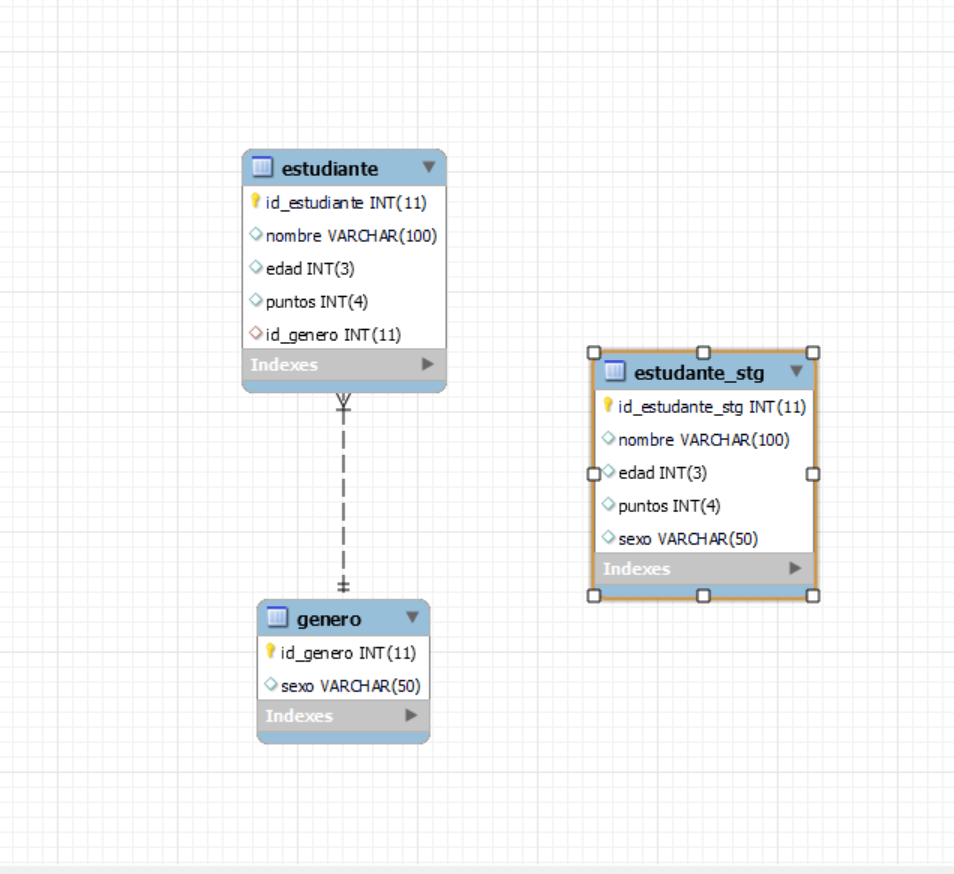

In [36]:
from IPython.display import Image

Image(filename='base_est.png')

### 3.2. Eliminar los datos de la base de datos

In [37]:
def eliminar_datos_base(conexion):
    try:
        # Desactivar las restricciones de clave externa para permitir la eliminación de datos
        cursor = conexion.cursor()
        cursor.execute("SET FOREIGN_KEY_CHECKS=0;")
        conexion.commit()
        cursor.close()

        # Limpiar la base de datos
        cursor = conexion.cursor()
        cursor.execute("DELETE FROM estudante_stg;")
        cursor.execute("DELETE FROM estudiante;")
        cursor.execute("DELETE FROM genero;")
        # Realizar más operaciones de eliminación si es necesario
        conexion.commit()
        cursor.close()
    except Exception as e:
        print(f"Error al limpiar la base de datos: {e}")
    finally:
        try:
            # Reactivar las restricciones de clave externa
            cursor = conexion.cursor()
            cursor.execute("SET FOREIGN_KEY_CHECKS=1;")
            cursor.close()
        except Exception as e:
            print(f"Error al reactivar las restricciones de clave externa: {e}")

# Llamar a la función eliminar_datos_base
eliminar_datos_base(conexion)


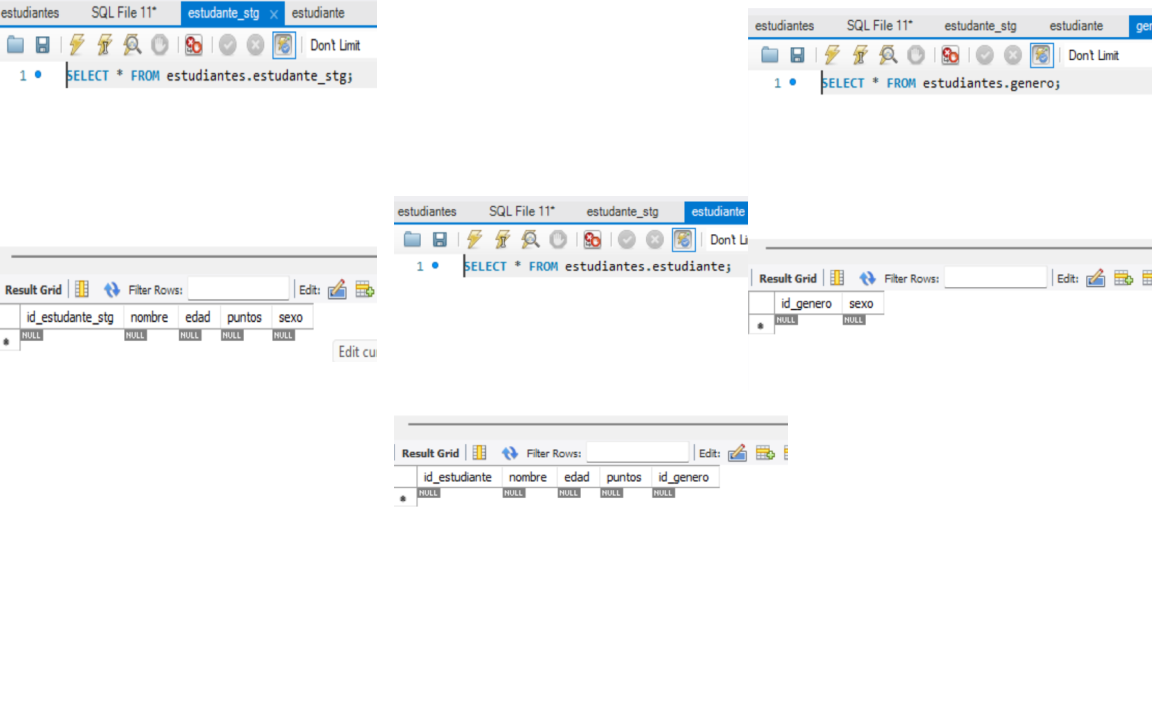

In [38]:
from IPython.display import Image

Image(filename='pato.png')

### 3.3. Insertar datos a la tabla estudiante_stg

In [39]:
  
def insert_estudiante_stg(conexion, df):
    cursor = conexion.cursor()

    insert_query = "INSERT INTO estudante_stg(nombre,edad,puntos, sexo) VALUES (%s, %s, %s, %s)"

    try:
        for index, row in df.iterrows():
            taxi_data = (row['Nombre'], row['Edad'], row['Puntuacion'], row['Sexo'])
            cursor.execute(insert_query, taxi_data)

        conexion.commit()
        print(f"Datos insertados correctamente")

    except Exception as e:
        print(f"Error al insertar datos: {e}")

    finally:
        cursor.close()

In [40]:
insert_estudiante_stg(conexion, df)

Datos insertados correctamente


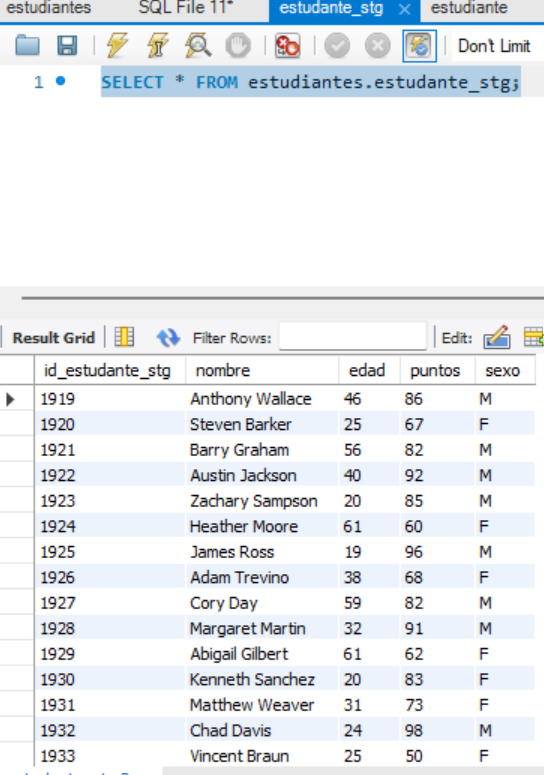

In [41]:
from IPython.display import Image

Image(filename='ganzo.png')

### 3.4. Limpiar datos innecesarios

In [42]:
def limpiar1_datos_estudiante_stg(conexion):
    try:
        # Desactivar las restricciones de clave externa para permitir la eliminación
        cursor = conexion.cursor()
        cursor.execute("SET FOREIGN_KEY_CHECKS=0;")
        cursor.close()

        # Eliminar datos de las tablas
        delete_queries = [
            'delete from estudante_stg where nombre is null;',
            'delete from estudante_stg where edad=0 or edad>90;',
            'delete from estudante_stg where puntos=0;',
            'delete from estudante_stg where sexo="Noid"'        
        ]

        for query in delete_queries:
            cursor = conexion.cursor()
            cursor.execute(query)
            cursor.close()

        # Confirmar los cambios
        conexion.commit()

        print("Datos tabla estudiante stg limpiada exitosamente.")

    except Exception as e:
        print(f"Error al limpiar la base de datos: {e}")

    finally:
        try:
            # Reactivar las restricciones de clave externa
            cursor = conexion.cursor()
            cursor.execute("SET FOREIGN_KEY_CHECKS=1;")
            cursor.close()
        except Exception as e:
            print(f"Error al reactivar las restricciones de clave externa: {e}")

# Llamar a la función limpiar_datos_taxi_stg
limpiar1_datos_estudiante_stg(conexion)


Datos tabla estudiante stg limpiada exitosamente.


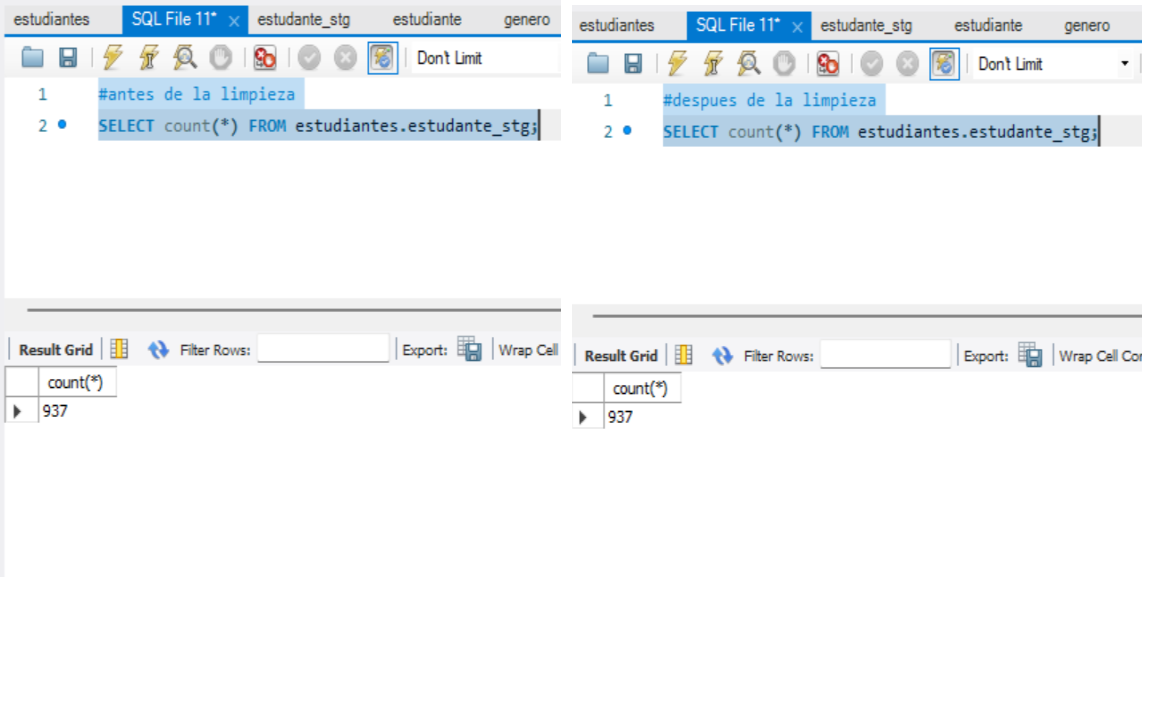

In [43]:
from IPython.display import Image

Image(filename='perro.png')

### 3.4. Obtener valores distintos y asignar a las respectivas tablas

In [44]:
def obtener_distinct_values(conexion, column_name):
    try:
        cursor = conexion.cursor()
        select_query = f"SELECT DISTINCT({column_name}) FROM estudante_stg"
        cursor.execute(select_query)
        distinct_values = cursor.fetchall()
        print(f"Datos extraidos correctamente de: {column_name}")
        return tuple(value[0] for value in distinct_values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []



In [45]:
distinct_values_genero=obtener_distinct_values(conexion, "sexo")

Datos extraidos correctamente de: sexo


### 3.5. Insertar los datos extraidos en las respectivas tablas

In [46]:
def insert_distinct_values_into_table(conexion, distinct_values, table_name, column_name):
    try:
        # Abrir el cursor para ejecutar la inserción de datos
        cursor = conexion.cursor()

        # Definir la consulta de inserción
        insert_query = f"INSERT INTO {table_name} ({column_name}) VALUES (%s)"

        # Iterar sobre los valores distintos y ejecutar la inserción
        for value in distinct_values:
            cursor.execute(insert_query, (value,))

        # Confirmar los cambios y cerrar el cursor
        conexion.commit()
        cursor.close()

        print(f"Datos insertados correctamente en {table_name}.")

    except Exception as e:
        print(f"Error al insertar datos en {table_name}: {e}")


In [47]:
insert_distinct_values_into_table(conexion, distinct_values_genero, "genero", "sexo")

Datos insertados correctamente en genero.


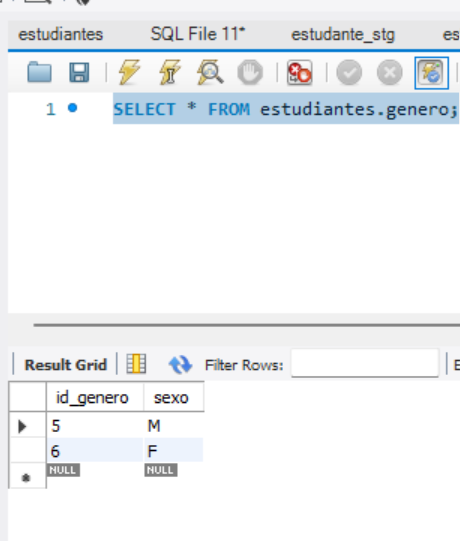

In [48]:
from IPython.display import Image

Image(filename='gato.png')

### 3.6. Obtener los valores relacionados con su respectivo ID

In [49]:
def obtener_valores_estudiante(conexion):
    try:
        with conexion.cursor() as cursor:
            select_query = '''
            SELECT estudante_stg.nombre, edad, puntos, genero.id_genero 
            FROM estudante_stg
            INNER JOIN genero ON estudante_stg.sexo = genero.sexo;
            '''
            cursor.execute(select_query)
            values = cursor.fetchall()
            return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []

In [50]:
def obtener_valores_estudiante(conexion):
    try:
        # Abrir el cursor para ejecutar la consulta
        cursor = conexion.cursor()

        # Definir la consulta SQL
        select_query = '''
        SELECT estudante_stg.nombre, edad, puntos, genero.id_genero 
        FROM estudante_stg
        INNER JOIN genero ON estudante_stg.sexo = genero.sexo;
        '''

        # Ejecutar la consulta
        cursor.execute(select_query)

        # Obtener los valores y cerrar el cursor
        values = cursor.fetchall()
        cursor.close()

        return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores de taxi: {e}")
        return ()



In [51]:
valores=obtener_valores_estudiante(conexion)

### 3.7. Insertar los valores en la tabla estudiante

In [52]:
def insert_tabla_estudiante(conexion, values):
    try:
        # Abrir el cursor para ejecutar la inserción de datos
        cursor = conexion.cursor()

        # Definir la consulta de inserción
        insert_query = "INSERT INTO estudiante (nombre, edad, puntos, id_genero) VALUES (%s, %s, %s, %s)"

        # Iterar sobre los valores y ejecutar la inserción
        for value in values:
            cursor.execute(insert_query, value)

        # Confirmar los cambios y cerrar el cursor
        conexion.commit()
        cursor.close()

        print("Datos insertados correctamente.")

    except Exception as e:
        print(f"Error al insertar datos: {e}")

def cerrar_conexion(conexion):
    if conexion:
        conexion.close()



In [53]:
insert_tabla_estudiante(conexion, valores)

Datos insertados correctamente.


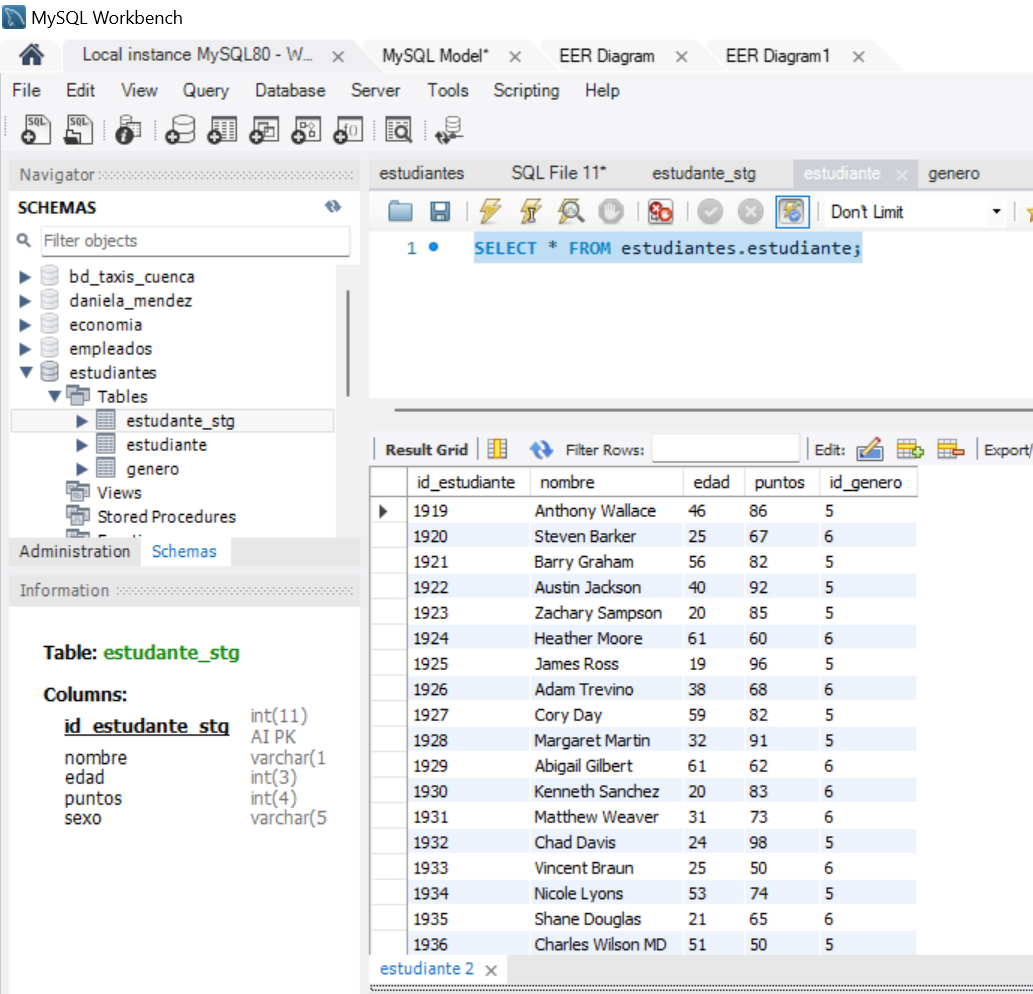

In [54]:
from IPython.display import Image

Image(filename='end.png')

Comprobar en la base de datos que se hayan insertado los datos correctamente y responder a las siguientes preguntas:

### 1. Diseño de la Base de Datos:

¿Cuál es la estructura de la base de datos utilizada en la práctica? 

¿Cómo están relacionadas las tablas entre sí?

### 2. Proceso de Extracción y Limpieza:

¿Cómo se realiza la extracción de datos desde el archivo Excel hacia un DataFrame de pandas?

¿Qué criterios se utilizaron para limpiar los datos innecesarios en la tabla taxi_stg?

### 3.Inserción de Datos:

¿Cuáles son los pasos específicos para insertar datos en la tabla taxi_stg desde el DataFrame de pandas?

¿Cómo se manejan los datos duplicados o los valores inconsistentes durante la inserción?

### 4.Obtención y Asignación de Valores Distintos:

¿Cómo se obtienen y asignan los valores distintos de las columnas categoria, tipo_taxi, clase y marca a sus respectivas tablas?

### 5.Relación de Datos y Carga Final:

¿Cómo se establecen las relaciones entre las tablas taxi_stg, clase, marca, categoria, tipo_taxi y taxi?

¿Cuál es el proceso final para cargar los datos en la tabla taxi?

# PARTE 2. LECTURA DE DATOS DESDE LA BASE DE DATOS Y VISUALIZACIÓN DE DATOS
### Objetivos:
##### Extraer los datos desde la base de Datos
##### Análisis Exploratorio Efectivo: Enseñar técnicas fundamentales de análisis exploratorio de datos, incluida la identificación y manejo de valores faltantes, así como la exploración de estadísticas descriptivas, para obtener una comprensión inicial de los conjuntos de datos.
##### Visualización Impactante: Introducir conceptos clave de visualización de datos utilizando Matplotlib y Seaborn, y explorar la integración de "PowerClient - Quick Report" para generar visualizaciones impactantes que resalten patrones y tendencias de manera clara y efectiva.

### 1: Importación de librerías

In [20]:
!pip install mysql.connector

In [21]:
import pandas as pd
import mysql.connector
import pandas as pd

### 2: Cargar los datos

In [22]:
def establecer_conexion(host, user, password, database):
    try:
        conexion = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        return conexion
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

            
def obtener_valores_taxi(conexion):
    try:
        with conexion.cursor() as cursor:
            select_query = '''
            SELECT * from taxi_stg;
            '''
            cursor.execute(select_query)
            values = cursor.fetchall()
            return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []

            
def cerrar_conexion(conexion):
    if conexion:
        conexion.close()


In [23]:
conexion = establecer_conexion("localhost", "root", "", "taxis")
conexion.is_connected()

True

In [24]:
datos_taxi=obtener_valores_taxi(conexion)

Error al obtener valores distintos: 'MySQLCursor' object does not support the context manager protocol


In [25]:
# Convertir la tupla en un DataFrame
columnas = ['Id','Placa', 'Clase', 'Marca', 'Año', 'Categoría', 'Tipo taxi']
df = pd.DataFrame(datos_taxi, columns=columnas)

In [26]:
df

,Id,Placa,Clase,Marca,Año,Categoría,Tipo taxi


In [27]:
# Eliminar la columna 'Id'
df = df.drop('Id', axis=1)

### 3: Librería Y-Data Profiling
https://docs.profiling.ydata.ai/4.6/ 

In [28]:
from ydata_profiling import ProfileReport

ModuleNotFoundError: No module named 'ydata_profiling'

In [ ]:
profile=ProfileReport(df,title="Análisis de datos")


In [ ]:
profile

### 4: Librería sweetviz

In [ ]:
import sweetviz as sv

In [ ]:
advert_report=sv.analyze([df,"Reporte DATOS"])

In [ ]:
advert_report.show_html()

###  5: Librería Power Bi

In [ ]:
#pip install powerbiclient

In [ ]:
from powerbiclient import QuickVisualize, get_dataset_config

In [ ]:
# Import the DeviceCodeLoginAuthentication class to authenticate against Power BI
from powerbiclient.authentication import DeviceCodeLoginAuthentication
    
# Initiate device authentication
device_auth = DeviceCodeLoginAuthentication()

In [ ]:
# Create a Power BI report from your data
PBI_visualize = QuickVisualize(get_dataset_config(df), auth=device_auth)

# Render new report
PBI_visualize

## 6: Preguntas

### 6.1. Extracción de Datos:

Describe el proceso de extracción de datos desde la base de datos MySQL. 

¿Qué consulta SQL se utiliza para obtener los datos de la tabla taxi_stg?

### 6.2. Visualización con Y-Data Profiling:

Basándote en el informe de Y-Data Profiling, ¿qué información relevante se destaca sobre el conjunto de datos? ¿Cómo interpretarías los resultados del análisis?

### 6.3. Visualización con Sweetviz:

¿Cuáles son las principales visualizaciones proporcionadas por Sweetviz? ¿Puedes identificar patrones o tendencias interesantes en el conjunto de datos?

### 6.4. Visualización con Power BI:

Explica el proceso de autenticación utilizado para conectar Python a Power BI. ¿Cómo se genera y visualiza el informe en Power BI utilizando el conjunto de datos?

### 6.5. Comparación de Librerías:

¿Cuáles son las diferencias clave entre Y-Data Profiling, Sweetviz y Power BI en términos de funcionalidad y visualización? ¿En qué situaciones específicas podrías preferir una sobre la otra?

### 6.6. Ejercicio de extracción de la tabla taxi con sus relaciones:

Realiza la exportación de los datos de la tabla taxi y sus relaciones y modela el dataframe similar al dado.

